In [1]:
# Importing necessary libraries
# !pip install optuna
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd.functional import jacobian as jac
from torch.func import jacfwd, vmap
from csv import writer
import os
import optuna

In [2]:
from Scripts.GetData import getDataLoaders, loadData
from Scripts.Utils import getBCs
from Scripts.Network import approximate_curve
from Scripts.Training import trainModel
from Scripts.PlotResults import plotTestResults
from Scripts.SavedParameters import hyperparams

In [3]:
#We do this so Pytorch works in double precision
torch.set_default_dtype(torch.float32)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
torch.manual_seed(1)
np.random.seed(1)

In [6]:
percentage_train = input("Choose percentage of training data between 80, 40, 20, and 10: ")
percentage_train = int(percentage_train)/100
percentage_train

Choose percentage of training data between 80, 40, 20, and 10: 80


0.8

In [7]:
batch_size = 1024
epochs = 100

In [8]:
num_nodes, trajectories_train, test_traj = loadData()
shuffle_idx_train = np.random.permutation(len(trajectories_train))
trajectories_train = trajectories_train[shuffle_idx_train]
test_traj = test_traj[shuffle_idx_train]

number_samples_train, number_components = trajectories_train.shape
indices_train = np.random.permutation(len(trajectories_train))
trajectories_train = trajectories_train[indices_train]
number_samples_test, _ = test_traj.shape
test_traj = test_traj[indices_train]

number_elements = int(number_components/4)-1
data_train, data_test, data_val, x_train, x_test, y_train, y_test, x_val, y_val, trainloader, testloader, valloader = getDataLoaders(batch_size, number_elements,number_samples_train, number_samples_test,trajectories_train, test_traj, percentage_train)

training_trajectories = np.concatenate((x_train[:,:4],y_train,x_train[:,-4:]),axis=1)
test_trajectories = np.concatenate((x_test[:,:4],y_test,x_test[:,-4:]),axis=1)
val_trajectories = np.concatenate((x_val[:,:4],y_val,x_val[:,-4:]),axis=1)

train :  (789, 8)
val :  (98, 8)
test :  (98, 8)


In [9]:
def define_model(trial):

    torch.manual_seed(1)
    np.random.seed(1)

    normalize = True
    netarch = 0
    
    if netarch == 0:
      is_mult = True
      is_res = False
    elif netarch == 1:
      is_mult = False
      is_res = True
    else:
      is_mult = False
      is_res = False
    act = 'tanh'
    nlayers = trial.suggest_int("n_layers", 3, 8)
    hidden_nodes = trial.suggest_int("hidden_nodes", 10, 200)
    model = approximate_curve(normalize, act, nlayers, hidden_nodes, correct_functional=False, is_res=is_res, is_mult=is_mult, both=False)
    return model

In [10]:
from itertools import chain

def flatten_chain(matrix):
    return list(chain.from_iterable(matrix))

q_idx = flatten_chain([[i,i+1] for i in np.arange(0,number_components,4)]) #indices of the qs
qp_idx = flatten_chain([[i+2,i+3] for i in np.arange(0,number_components,4)]) #indices of the q's

In [11]:
def objective(trial):

    torch.manual_seed(1)
    np.random.seed(1)

    model = define_model(trial)
    model.to(device);

    lr = 1e-3
    weight_decay = 0
    optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)
    criterion = nn.MSELoss()
    _, _, _, _, _, _, _, _, _, trainloader, testloader, valloader = getDataLoaders(batch_size, number_elements,number_samples_train, number_samples_test,trajectories_train, test_traj, percentage_train)

    print("Current test with :\n\n")
    for key, value in trial.params.items():
      print("    {}: {}".format(key, value))
    print("\n\n")

    loss = trainModel(number_elements,device,model,criterion,optimizer,epochs,trainloader,valloader,train_with_tangents=False,pde_regularisation=False,soft_bcs_imposition=False)
    val_error = 100
    if not torch.isnan(loss):
        model.eval();

        def eval_model(model,device,s,q1,q2,v1,v2):
            s_ = torch.tensor([[s]],dtype=torch.float32).to(device)
            q1 = torch.from_numpy(q1.astype(np.float32)).reshape(1,-1).to(device)
            q2 = torch.from_numpy(q2.astype(np.float32)).reshape(1,-1).to(device)
            v1 = torch.from_numpy(v1.astype(np.float32)).reshape(1,-1).to(device)
            v2 = torch.from_numpy(v2.astype(np.float32)).reshape(1,-1).to(device)
            return model(s_,q1,q2,v1,v2).detach().cpu().numpy()[0]

        def eval_derivative_model(model,device,s,q1,q2,v1,v2):
            s_ = torch.tensor([[s]],dtype=torch.float32).to(device)
            q1 = torch.from_numpy(q1.astype(np.float32)).reshape(1,-1).to(device)
            q2 = torch.from_numpy(q2.astype(np.float32)).reshape(1,-1).to(device)
            v1 = torch.from_numpy(v1.astype(np.float32)).reshape(1,-1).to(device)
            v2 = torch.from_numpy(v2.astype(np.float32)).reshape(1,-1).to(device)

            return model.derivative(s_,q1,q2,v1,v2).detach().cpu().numpy().reshape(-1)

        bcs = getBCs(val_trajectories)
        q1 = bcs["q1"]
        q2 = bcs["q2"]
        v1 = bcs["v1"]
        v2 = bcs["v2"]

        q1 = torch.from_numpy(bcs["q1"].astype(np.float32)).to(device)
        q2 = torch.from_numpy(bcs["q2"].astype(np.float32)).to(device)
        v1 = torch.from_numpy(bcs["v1"].astype(np.float32)).to(device)
        v2 = torch.from_numpy(bcs["v2"].astype(np.float32)).to(device)

        q_idx = flatten_chain([[i,i+1] for i in np.arange(0,number_components,4)]) #indices of the qs
        qp_idx = flatten_chain([[i+2,i+3] for i in np.arange(0,number_components,4)]) #indices of the q's

        xx = torch.linspace(0,1,number_elements+1).unsqueeze(1).repeat(len(q1),1).to(device)
        one = torch.ones((number_elements+1,1)).to(device)
        q1_augmented = torch.kron(q1,one)
        q2_augmented = torch.kron(q2,one)
        v1_augmented = torch.kron(v1,one)
        v2_augmented = torch.kron(v2,one)

        pred_val_q = model(xx,q1_augmented,q2_augmented,v1_augmented,v2_augmented).reshape(len(q1),-1).detach().cpu().numpy()
        val_error_q = np.mean((pred_val_q-val_trajectories[:,q_idx])**2)
        pred_val_qp = model.derivative(xx,q1_augmented,q2_augmented,v1_augmented,v2_augmented).reshape(len(q1),-1).detach().cpu().numpy()
        val_error_qp = np.mean((pred_val_qp-val_trajectories[:,qp_idx])**2)
        pred_val_all = np.zeros_like(val_trajectories)
        pred_val_all[:, q_idx] = pred_val_q
        pred_val_all[:, qp_idx] = pred_val_qp
        val_error = np.mean((pred_val_all-val_trajectories)**2)

#     #Saving the obtained results
#     if trial.number == 0:
#         labels = []
#         for lab, _ in trial.params.items():
#             labels.append(str(lab))
#         labels.append("Test error")
#         with open("SavedResults.csv", "a") as f_object:
#             writer_object = writer(f_object)
#             writer_object.writerow(labels)
#             writer_object.writerow(f"\n\n Percentage of training data: {percentage_train}")
#             f_object.close()

#     results = []
#     for _, value in trial.params.items():
#         results.append(str(value))

#     results.append(val_error)

#     with open("SavedResults.csv", "a") as f_object:
#         writer_object = writer(f_object)
#         writer_object.writerow(results)
#         f_object.close()

    return val_error

In [12]:
optuna_study = input("Do you want to do hyperparameter test? Type yes or no ")
params = {}
if optuna_study=="yes":
    optuna_study = True
else:
    optuna_study = False
if optuna_study:
    study = optuna.create_study(direction="minimize",study_name="Euler Elastica")
    study.optimize(objective, n_trials=300)
    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    params = study.best_params

Do you want to do hyperparameter test? Type yes or no no


In [13]:
torch.manual_seed(1)
np.random.seed(1)

In [14]:
manual_input = False
if params=={}:
    # We can input them manually by uncommenting the lines below
    if manual_input:
        print("No parameters have been specified. Let's input them:\n\n")
        nlayers = int(input("How many layers do you want the network to have? "))
        hidden_nodes = int(input("How many hidden nodes do you want the network to have? "))
        params = {"n_layers":nlayers,
                "hidden_nodes":hidden_nodes}
    else:
    # or we can use the combinations found by Optuna that yield the best results for the mentioned datacases
        params = hyperparams(percentage_train)

In [15]:
print(f'The hyperparameters yelding the best results for this case are: {params}')

The hyperparameters yelding the best results for this case are: {'n_layers': 6, 'hidden_nodes': 106}


In [16]:
def define_best_model():
    normalize = True  
    act = 'tanh'
    nlayers = params["n_layers"]
    hidden_nodes = params["hidden_nodes"]
    
    is_mult = True
    is_res = False
    model = approximate_curve(normalize, act, nlayers, hidden_nodes, correct_functional=False, is_res=is_res, is_mult=is_mult, both=False)

    return model

In [17]:
model = define_best_model()
model.to(device);

In [18]:
TrainMode = input("Train Mode True or False? Type 0 for False and 1 for True: ")
TrainMode = int(TrainMode)
if TrainMode == 0:
    TrainMode = False
else:
    TrainMode = True
TrainMode

Train Mode True or False? Type 0 for False and 1 for True: 0


False

In [19]:
weight_decay = 0
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)

criterion = nn.MSELoss()

_, _, _, _, _, _, _, _, _, trainloader, testloader, valloader = getDataLoaders(batch_size, number_elements,number_samples_train, number_samples_test,trajectories_train, test_traj, percentage_train)
model.to(device);

if TrainMode:
    loss = trainModel(number_elements,device,model,criterion,optimizer,epochs,trainloader,valloader, train_with_tangents=False,pde_regularisation=False,soft_bcs_imposition=False)
    if percentage_train == 0.8:
        torch.save(model.state_dict(), 'TrainedModels/BothEnds0.8data.pt')
    elif percentage_train == 0.4:
        torch.save(model.state_dict(), 'TrainedModels/BothEnds0.4data.pt')
    elif percentage_train == 0.2:
        torch.save(model.state_dict(), 'TrainedModels/BothEnds0.2data.pt')
    else:
        torch.save(model.state_dict(), 'TrainedModels/BothEnds0.1data.pt')
else:
    if percentage_train == 0.8:
        pretrained_dict = torch.load(f'TrainedModels/BothEnds0.8data.pt',map_location=device)
    elif percentage_train == 0.4:
        pretrained_dict = torch.load(f'TrainedModels/BothEnds0.4data.pt',map_location=device)
    elif percentage_train == 0.2:
        pretrained_dict = torch.load(f'TrainedModels/BothEnds0.2data.pt',map_location=device)
    else:
        pretrained_dict = torch.load(f'TrainedModels/BothEnds0.1data.pt',map_location=device)
    model.load_state_dict(pretrained_dict)


train :  (789, 8)
val :  (98, 8)
test :  (98, 8)


Error over training trajectories: 3.553858882915369e-06.
Error over validation trajectories: 4.778953819892178e-06.
Error over test trajectories: 4.354318294399419e-06.
Error over all trajectories: 3.755386117584571e-06.


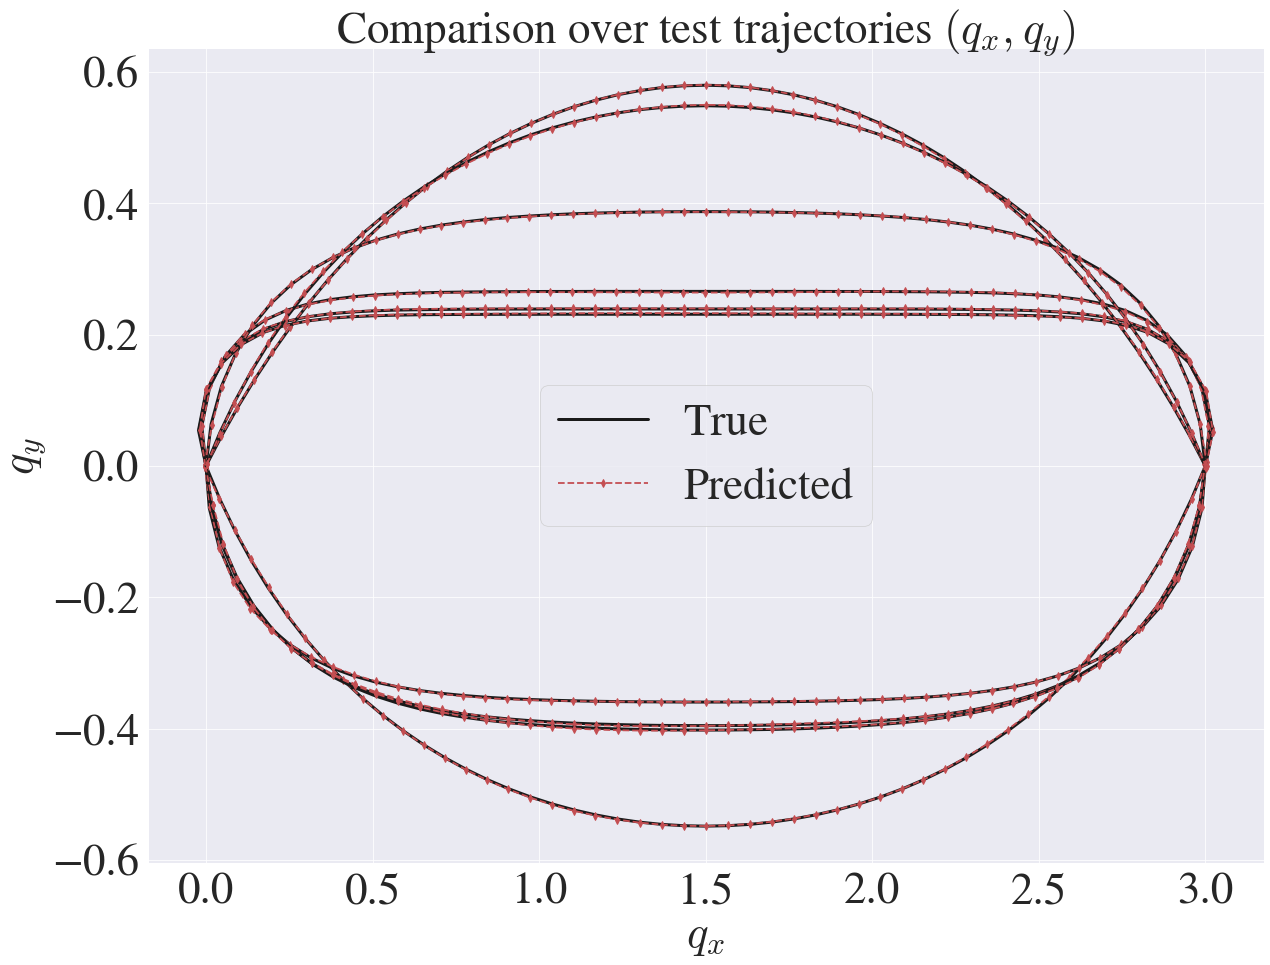

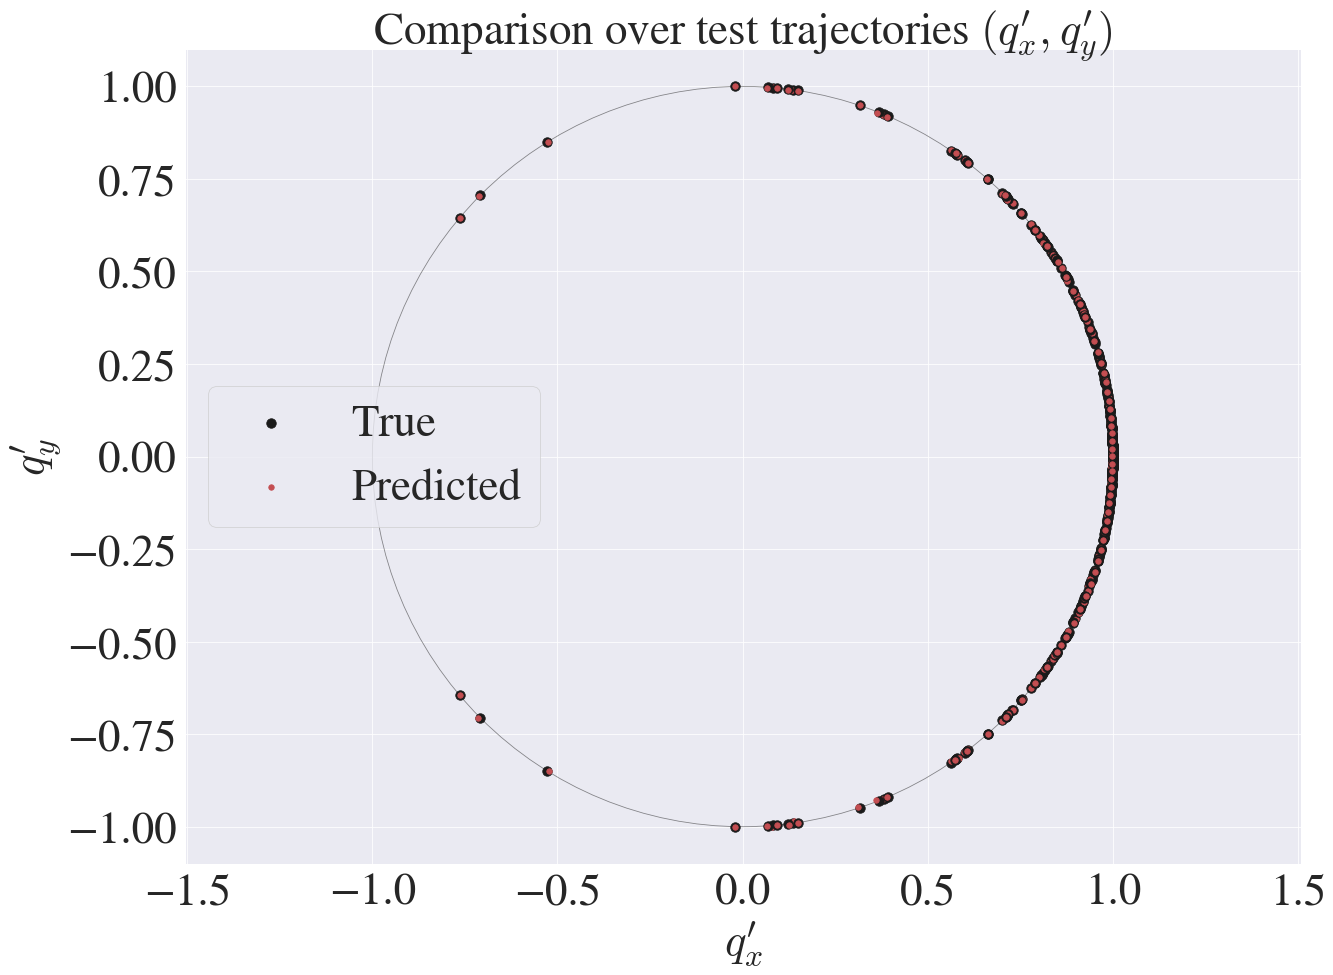

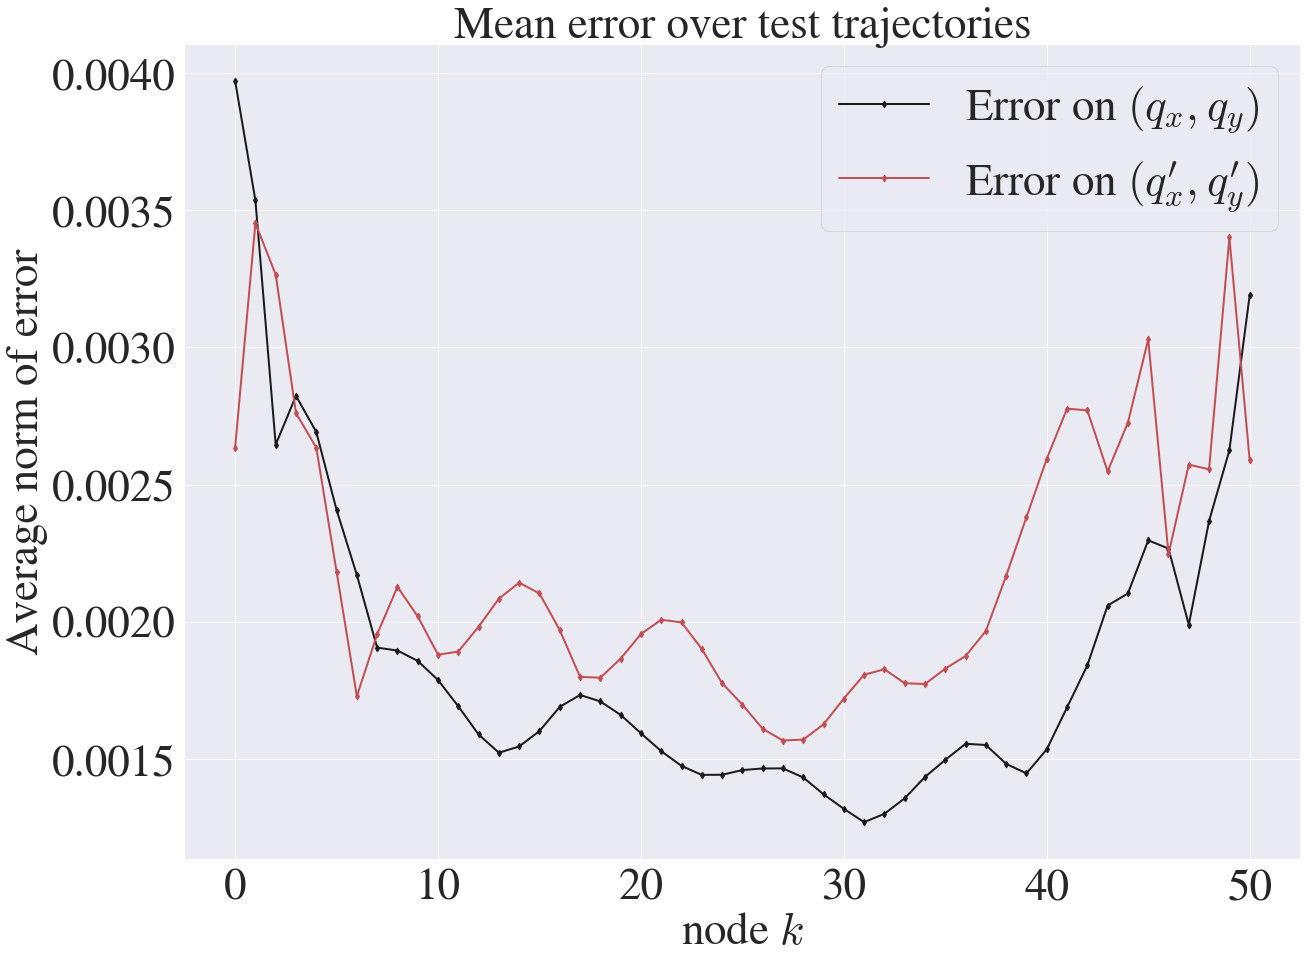

In [20]:
# printing the accuracies and plotting the results

model.eval();
res,res_derivative = plotTestResults(model,device,number_elements,number_components,x_train,x_val,x_test,y_train,y_val,y_test, num_nodes, percentage_train)